## 크롤링 🧐

In [1]:
# 1. 프로젝트 생성

In [2]:
import scrapy, requests, re
from scrapy.http import TextResponse

In [3]:
!rm -rf musinsa
!scrapy startproject musinsa

New Scrapy project 'musinsa', using template directory '/home/ubuntu/.pyenv/versions/3.6.9/envs/python3/lib/python3.6/site-packages/scrapy/templates/project', created in:
    /home/ubuntu/python3/notebook/project/crawling-repo-3/musinsa

You can start your first spider with:
    cd musinsa
    scrapy genspider example example.com


In [4]:
!ls

README.md  mss-crawler-top.ipynb  musinsa


In [5]:
!tree musinsa/

musinsa/
├── musinsa
│   ├── __init__.py
│   ├── items.py
│   ├── middlewares.py
│   ├── pipelines.py
│   ├── settings.py
│   └── spiders
│       └── __init__.py
└── scrapy.cfg

2 directories, 7 files


In [6]:
# 2. xpath 확인

In [7]:
# link

In [8]:
req = requests.get("https://search.musinsa.com/category/001003")
response = TextResponse(req.url, body=req.text, encoding="utf-8")

In [9]:
links = response.xpath('//*[@id="searchList"]/li/div[contains(@class,"li_inner")]\
/div[2]/p[2]/a/@href').extract()
len(links), links[0]

(90, 'https://store.musinsa.com/app/goods/855195')

In [10]:
# info

In [211]:
# class MusinsaItem(scrapy.Item):
#     title = scrapy.Field()
#     brand = scrapy.Field()
#     o_price = scrapy.Field()
#     s_price = scrapy.Field()
#     kw = scrapy.Field()
#     img_link = scrapy.Field()
#     link = scrapy.Field()
#     item_id = scrapy.Field()
#     most_age = scrapy.Field()
#     most_sex = scrapy.Field()
#     colors = scrapy.Field()
#     sizes = scrapy.Field()
#     size_details = scrapy.Field()

In [11]:
link = links[0]
print(link)

https://store.musinsa.com/app/goods/855195


In [13]:
req = requests.get(link)
response = TextResponse(req.url, body=req.text, encoding="utf-8")

In [15]:
title = response.xpath('/html/head/title/text()')[0].extract().split(' -')[0]
title = title.split(') ')[1]
brand = response.xpath('//*[@id="product_order_info"]/div[1]/ul/li[1]/p[2]/strong/a/text()')[0].extract()
try: # 세일가 있는 상품
    o_price = response.xpath('//*[@id="goods_price"]/del/text()')[0].extract().strip()
except: # 판매가만 있는 상품
    o_price = response.xpath('//*[@id="goods_price"]/text()')[0].extract().strip()
try:
    s_price = response.xpath('//*[@id="sale_price"]/text()')[0].extract().strip()
except:
    s_price = o_price
try:
    kw = response.xpath('//*[@id="product_order_info"]/div[1]/ul/li[7]/p/a/text()').extract()
except:
    kw = ''
img_link = "https:" + response.xpath('//*[@id="detail_bigimg"]/div[1]/img/@src')[0].extract()


title, brand, o_price, s_price, kw, img_link

('원버튼 더블 피케 티_블랙',
 'BLANK ROOM',
 '43,000',
 '40,850',
 ['#긴팔', '#긴팔티', '#미니멀', '#셔츠', '#원버튼', '#카라티', '#티셔츠'],
 'https://image.msscdn.net/images/goods_img/20180911/855195/855195_2_500.jpg')

### selenium

In [16]:
from selenium import webdriver

In [17]:
options = webdriver.ChromeOptions()
options.add_argument("headless")

In [21]:
url = "https://store.musinsa.com/app/goods/659554"

In [22]:
driver = webdriver.Chrome(options=options)        
driver.get(url)

In [23]:
most_age = driver.find_elements_by_xpath('//*[@id="graph_summary_area"]/strong[1]')[0].text
most_age

'19~23세'

In [24]:
most_sex = driver.find_elements_by_xpath('//*[@id="graph_summary_area"]/span[1]')[0].text
most_sex

'남성'

In [25]:
most = driver.find_elements_by_xpath('//*[@id="graph_summary_area"]')[0].text
most = most.split(' 이')[0]
most.replace(" ,", "")

'19~23세 남성'

In [26]:
option1_ls = driver.find_elements_by_xpath('//*[@id="option1"]/option[not(@value="")]')
option1 = [option.get_attribute("value") for option in option1_ls]
driver.find_element_by_xpath('//*[@id="option1"]/option[not(@value="")]').click()

option2_ls = driver.find_elements_by_xpath('//*[@id="option2"]/option[not(@value="")]')
option2 = [option.get_attribute("value") for option in option2_ls]
# driver.find_element_by_xpath('//*[@id="option2"]/option[not(@value="")]').click()

option3_ls = driver.find_elements_by_xpath('//*[@id="addopt1"]/option[not(@value="")]')
option3 = [option.text for option in option3_ls]

option4_ls = driver.find_elements_by_xpath('//*[@id="addopt2"]/option[not(@value="")]')
option4 = [option.text for option in option4_ls]

most_age = driver.find_elements_by_xpath('//*[@id="graph_summary_area"]/strong[1]')[0].text
most_sex = driver.find_elements_by_xpath('//*[@id="graph_summary_area"]/span[1]')[0].text

option1, option2, option3, option4, most_age, most_sex

(['블랙', '그레이', '아이보리', '카키', '베이지', '와인', '오프화이트', '그레이쉬 민트', '차콜', '더스티 블루'],
 ['M', 'L', 'XL'],
 ['블랙', '그레이', '아이보리', '와인'],
 ['M', 'L', 'XL'],
 '19~23세',
 '남성')

In [29]:
driver.quit()

In [14]:
# 3. items.py

In [30]:
%%writefile musinsa/musinsa/items.py
import scrapy


class MusinsaItem(scrapy.Item):
    title = scrapy.Field()
    brand = scrapy.Field()
    o_price = scrapy.Field()
    s_price = scrapy.Field()
    kw = scrapy.Field()
    img_link = scrapy.Field()
    link = scrapy.Field()

Overwriting musinsa/musinsa/items.py


In [16]:
# 4. spider.py

In [31]:
%%writefile musinsa/musinsa/spiders/spider.py

import scrapy
from musinsa.items import MusinsaItem


class Spider(scrapy.Spider):
    name = "Musinsa"
    allow_domain = ["musinsa.com"]
    start_urls = ["https://search.musinsa.com/category/001003"]

    def parse(self, response):
        links = response.xpath('//*[@id="searchList"]/li/div[contains(@class,"li_inner")]\
/div[2]/p[2]/a/@href').extract()
        for link in links:
            yield scrapy.Request(link, callback=self.parse_content)
            
    def parse_content(self, response):
        item = MusinsaItem()
        title = response.xpath('/html/head/title/text()')[0].extract().split(' -')[0]
        item["title"] = title.split(') ')[1]
        item["brand"] = response.xpath('//*[@id="product_order_info"]/div[1]/ul/li[1]/p[2]/strong/a/text()')[0].extract()
        try: # 세일가 있는 상품
            item["o_price"] = response.xpath('//*[@id="goods_price"]/del/text()')[0].extract().strip()
        except: # 판매가만 있는 상품
            item["o_price"] = response.xpath('//*[@id="goods_price"]/text()')[0].extract().strip()
        try:
            item["s_price"] = response.xpath('//*[@id="sale_price"]/text()')[0].extract().strip()
        except:
            item["s_price"] = item["o_price"]
        try:
            item["kw"] = response.xpath('//*[@id="product_order_info"]/div[1]/ul/li[7]/p/a/text()').extract()
        except:
            item["kw"] = ''
        item["img_link"] = "https:" + response.xpath('//*[@id="detail_bigimg"]/div[1]/img/@src')[0].extract()
        item["link"] = response.url
        yield item       

Writing musinsa/musinsa/spiders/spider.py


In [21]:
# 5. run scrapy

In [32]:
%%writefile run.sh
cd musinsa
scrapy crawl Musinsa -o top.csv

Writing run.sh


In [24]:
# settings.py 변경

In [33]:
!head -n 20 musinsa/musinsa/settings.py | tail -n 2

# Obey robots.txt rules
ROBOTSTXT_OBEY = True


In [34]:
!sed -i 's/ROBOTSTXT_OBEY = True/ROBOTSTXT_OBEY = False/' musinsa/musinsa/settings.py

In [35]:
!head -n 20 musinsa/musinsa/settings.py | tail -n 2

# Obey robots.txt rules
ROBOTSTXT_OBEY = False


In [36]:
!/bin/bash run.sh

2021-02-24 17:06:46 [scrapy.utils.log] INFO: Scrapy 2.4.1 started (bot: musinsa)
2021-02-24 17:06:46 [scrapy.utils.log] INFO: Versions: lxml 4.6.2.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 20.3.0, Python 3.6.9 (default, Dec 15 2020, 04:39:26) - [GCC 7.5.0], pyOpenSSL 20.0.1 (OpenSSL 1.1.1i  8 Dec 2020), cryptography 3.3.1, Platform Linux-5.4.0-1037-aws-x86_64-with-debian-buster-sid
2021-02-24 17:06:46 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor
2021-02-24 17:06:46 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'musinsa',
 'NEWSPIDER_MODULE': 'musinsa.spiders',
 'SPIDER_MODULES': ['musinsa.spiders']}
2021-02-24 17:06:46 [scrapy.extensions.telnet] INFO: Telnet Password: 051f852a03395fa3
2021-02-24 17:06:46 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.F

2021-02-24 17:06:47 [scrapy.core.scraper] DEBUG: Scraped from <200 https://store.musinsa.com/app/goods/1808993>
{'brand': 'RENOMA GOLF',
 'img_link': 'https://image.msscdn.net/images/goods_img/20210223/1808993/1808993_1_500.jpg',
 'kw': [],
 'link': 'https://store.musinsa.com/app/goods/1808993',
 'o_price': '179,000',
 's_price': '179,000',
 'title': '21SS 여성 사선 지퍼 카라 배색 티셔츠 RWTHK5154-199_G'}
2021-02-24 17:06:47 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://store.musinsa.com/app/goods/1809009> (referer: https://search.musinsa.com/category/001003)
2021-02-24 17:06:47 [scrapy.core.scraper] DEBUG: Scraped from <200 https://store.musinsa.com/app/goods/1809011>
{'brand': 'RENOMA GOLF',
 'img_link': 'https://image.msscdn.net/images/goods_img/20210223/1809011/1809011_1_500.jpg',
 'kw': [],
 'link': 'https://store.musinsa.com/app/goods/1809011',
 'o_price': '149,000',
 's_price': '149,000',
 'title': '21SS 남성 앞판 가로 프린트 포인트 카라 티셔츠 RMTYK1153-199_G'}
2021-02-24 17:06:47 [scrapy.core.engi

2021-02-24 17:06:48 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://store.musinsa.com/app/goods/1793678> (referer: https://search.musinsa.com/category/001003)
2021-02-24 17:06:48 [scrapy.core.scraper] DEBUG: Scraped from <200 https://store.musinsa.com/app/goods/1793688>
{'brand': 'IMPERIAL',
 'img_link': 'https://image.msscdn.net/images/goods_img/20210215/1793688/1793688_1_500.jpg',
 'kw': [],
 'link': 'https://store.musinsa.com/app/goods/1793688',
 'o_price': '39,900',
 's_price': '39,900',
 'title': '남성 메쉬 자가드 티셔츠 레드 (INY120176)'}
2021-02-24 17:06:48 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://store.musinsa.com/app/goods/1793657> (referer: https://search.musinsa.com/category/001003)
2021-02-24 17:06:48 [scrapy.core.scraper] DEBUG: Scraped from <200 https://store.musinsa.com/app/goods/1793651>
{'brand': 'IMPERIAL',
 'img_link': 'https://image.msscdn.net/images/goods_img/20210215/1793651/1793651_1_500.jpg',
 'kw': [],
 'link': 'https://store.musinsa.com/app/goods/1793

2021-02-24 17:06:48 [scrapy.core.scraper] DEBUG: Scraped from <200 https://store.musinsa.com/app/goods/1793602>
{'brand': 'IMPERIAL',
 'img_link': 'https://image.msscdn.net/images/goods_img/20210215/1793602/1793602_1_500.jpg',
 'kw': [],
 'link': 'https://store.musinsa.com/app/goods/1793602',
 'o_price': '59,000',
 's_price': '59,000',
 'title': '남성 투톤 스트라이프 카라 티셔츠 네이비 (I0Z130849)'}
2021-02-24 17:06:49 [scrapy.core.scraper] DEBUG: Scraped from <200 https://store.musinsa.com/app/goods/1792554>
{'brand': 'BEANPOLE MEN',
 'img_link': 'https://image.msscdn.net/images/goods_img/20210215/1792554/1792554_1_500.jpg',
 'kw': [],
 'link': 'https://store.musinsa.com/app/goods/1792554',
 'o_price': '109,000',
 's_price': '109,000',
 'title': '[GREEN BEANPOLE] Unisex 화이트 피케 라인 칼라 티셔츠 (BC1342N031)'}
2021-02-24 17:06:49 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://store.musinsa.com/app/goods/1796538> (referer: https://search.musinsa.com/category/001003)
2021-02-24 17:06:49 [scrapy.core.scra

2021-02-24 17:06:49 [scrapy.core.scraper] DEBUG: Scraped from <200 https://store.musinsa.com/app/goods/1798793>
{'brand': 'LECOQ GOLF',
 'img_link': 'https://image.msscdn.net/images/goods_img/20210217/1798793/1798793_1_500.jpg',
 'kw': [],
 'link': 'https://store.musinsa.com/app/goods/1798793',
 'o_price': '168,000',
 's_price': '168,000',
 'title': '남성 기하학 패턴 긴팔 티셔츠'}
2021-02-24 17:06:49 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://store.musinsa.com/app/goods/1800419> (referer: https://search.musinsa.com/category/001003)
2021-02-24 17:06:49 [scrapy.core.scraper] DEBUG: Scraped from <200 https://store.musinsa.com/app/goods/1797535>
{'brand': 'BEANPOLE GOLF',
 'img_link': 'https://image.msscdn.net/images/goods_img/20210217/1797535/1797535_1_500.jpg',
 'kw': [],
 'link': 'https://store.musinsa.com/app/goods/1797535',
 'o_price': '179,000',
 's_price': '179,000',
 'title': '여성 아이보리 우븐 믹스 스트링 칼라 티셔츠 (BJ1342A160)'}
2021-02-24 17:06:49 [scrapy.core.engine] DEBUG: Crawled (200) <GET

2021-02-24 17:06:50 [scrapy.core.scraper] DEBUG: Scraped from <200 https://store.musinsa.com/app/goods/1801113>
{'brand': 'LAB12',
 'img_link': 'https://image.msscdn.net/images/goods_img/20210218/1801113/1801113_1_500.jpg',
 'kw': ['#폴로', '#카라티셔츠', '#오픈카라', '#폴로티', '#카라', '#출근룩', '#카라티'],
 'link': 'https://store.musinsa.com/app/goods/1801113',
 'o_price': '35,000',
 's_price': '31,500',
 'title': '21S/S 오버핏 피케티셔츠 (그레이블루)'}
2021-02-24 17:06:50 [scrapy.core.scraper] DEBUG: Scraped from <200 https://store.musinsa.com/app/goods/1066105>
{'brand': 'DRAW FIT',
 'img_link': 'https://image.msscdn.net/images/goods_img/20190607/1066105/1066105_1_500.jpg',
 'kw': ['#루즈핏반팔티', '#반팔', '#오버사이즈', '#오버핏반팔티', '#카라티'],
 'link': 'https://store.musinsa.com/app/goods/1066105',
 'o_price': '42,000',
 's_price': '37,800',
 'title': '오픈카라 티셔츠 [NAVY]'}
2021-02-24 17:06:50 [scrapy.core.scraper] DEBUG: Scraped from <200 https://store.musinsa.com/app/goods/1809016>
{'brand': 'RENOMA GOLF',
 'img_link': 'https://im

2021-02-24 17:06:51 [scrapy.core.scraper] DEBUG: Scraped from <200 https://store.musinsa.com/app/goods/1031258>
{'brand': 'LAB12',
 'img_link': 'https://image.msscdn.net/images/goods_img/20190430/1031258/1031258_4_500.jpg',
 'kw': ['#반팔PK티셔츠', '#카라티셔츠', '#PK티셔츠'],
 'link': 'https://store.musinsa.com/app/goods/1031258',
 'o_price': '35,000',
 's_price': '31,500',
 'title': '21S/S 오버핏 피케티셔츠 (브라운)'}
2021-02-24 17:06:51 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://store.musinsa.com/app/goods/1020313> (referer: https://search.musinsa.com/category/001003)
2021-02-24 17:06:51 [scrapy.core.scraper] DEBUG: Scraped from <200 https://store.musinsa.com/app/goods/1031260>
{'brand': 'LAB12',
 'img_link': 'https://image.msscdn.net/images/goods_img/20190430/1031260/1031260_4_500.jpg',
 'kw': ['#반팔PK티셔츠', '#카라티셔츠', '#PK티셔츠'],
 'link': 'https://store.musinsa.com/app/goods/1031260',
 'o_price': '35,000',
 's_price': '31,500',
 'title': '21S/S 오버핏 피케티셔츠 (블랙)'}
2021-02-24 17:06:51 [scrapy.core.en

In [37]:
import pandas as pd

In [40]:
pd.read_csv('musinsa/top.csv').head(10)

,brand,img_link,kw,link,o_price,s_price,title
0,ROMANTIC CROWN,https://image.msscdn.net/images/goods_img/2021...,NaN,https://store.musinsa.com/app/goods/1793069,"68,000","61,200",클래식 체크 피케 셔츠_네이비
1,ROMANTIC CROWN,https://image.msscdn.net/images/goods_img/2021...,NaN,https://store.musinsa.com/app/goods/1793083,"82,000","73,800",숄 카라 니트_오트밀
2,ROMANTIC CROWN,https://image.msscdn.net/images/goods_img/2021...,NaN,https://store.musinsa.com/app/goods/1793082,"82,000","73,800",숄 카라 니트_네이비
3,BLANK ROOM,https://image.msscdn.net/images/goods_img/2018...,"#긴팔,#긴팔티,#미니멀,#셔츠,#원버튼,#카라티,#티셔츠",https://store.musinsa.com/app/goods/855195,"43,000","40,850",원버튼 더블 피케 티_블랙
4,ROMANTIC CROWN,https://image.msscdn.net/images/goods_img/2021...,NaN,https://store.musinsa.com/app/goods/1793078,"78,000","70,200",콘트라스트 니트 폴로_그린
5,ROMANTIC CROWN,https://image.msscdn.net/images/goods_img/2021...,NaN,https://store.musinsa.com/app/goods/1793070,"68,000","61,200",클래식 체크 피케 셔츠_오트밀
6,ROMANTIC CROWN,https://image.msscdn.net/images/goods_img/2021...,NaN,https://store.musinsa.com/app/goods/1793079,"78,000","70,200",콘트라스트 니트 폴로_베이지
7,SUARE,https://image.msscdn.net/images/goods_img/2021...,NaN,https://store.musinsa.com/app/goods/1809949,"104,000","78,000",린넨 카라 니트 세트
8,RENOMA GOLF,https://image.msscdn.net/images/goods_img/2021...,NaN,https://store.musinsa.com/app/goods/1809020,"169,000","169,000",21SS 남성 소재 믹스 배색 카라 티셔츠 RMTYK1105-199_G
9,RENOMA GOLF,https://image.msscdn.net/images/goods_img/2021...,NaN,https://store.musinsa.com/app/goods/1808993,"179,000","179,000",21SS 여성 사선 지퍼 카라 배색 티셔츠 RWTHK5154-199_G


## 이미지 저장

In [39]:
test['img'].head(10)

0    https://image.msscdn.net/images/goods_img/2021...
1    https://image.msscdn.net/images/goods_img/2021...
2    https://image.msscdn.net/images/goods_img/2021...
3    https://image.msscdn.net/images/goods_img/2021...
4    https://image.msscdn.net/images/goods_img/2021...
5    https://image.msscdn.net/images/goods_img/2021...
6    https://image.msscdn.net/images/goods_img/2021...
7    https://image.msscdn.net/images/goods_img/2018...
8    https://image.msscdn.net/images/goods_img/2021...
9    https://image.msscdn.net/images/goods_img/2021...
Name: img, dtype: object

In [210]:
test['img'][0]

'https://image.msscdn.net/images/goods_img/20210215/1793069/1793069_2_500.jpg'

In [64]:
test['link'][0].split('/')[5]

'1793069'

In [78]:
import os

In [79]:
if not os.path.exists("datas"):
    os.makedirs("datas")

In [80]:
%ls

datas/  musinsa/  musinsa_0223.ipynb  run.sh


In [81]:
def save_file(title, link):
    response = requests.get(link)
    with open("datas/{}.png".format(title), "wb") as f:
        f.write(response.content)

In [82]:
for idx, data in test.iterrows():
    print(idx, end=" ")
    link = test['img'][idx]
    save_file(test['link'][idx].split('/')[5], link)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 

In [83]:
img_datas = !ls datas

In [84]:
img_datas[:2]

['1020313.png', '1031256.png']

In [85]:
# pillow로 이미지 출력

In [86]:
from PIL import Image as pil

In [96]:
img_datas[34]

'1793667.png'

In [107]:
img_obj = pil.open("datas/{}".format(img_datas[11]))

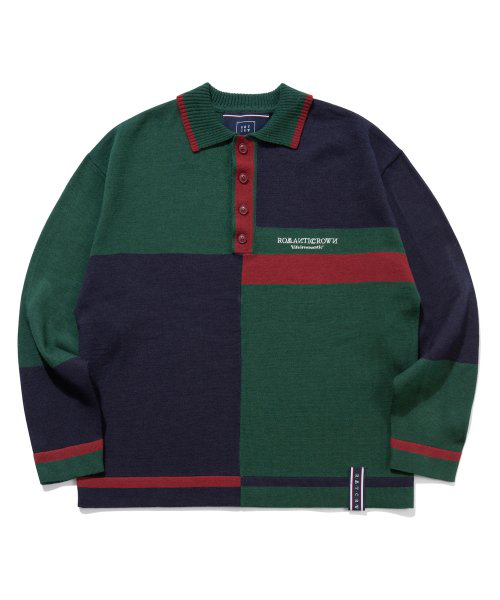

In [108]:
img_obj